In [1]:
# import typing
from local_fenics.base import *
import json
import shutil
import os
# Solving
import dolfinx
from dolfinx import mesh, fem, io, nls
from dolfinx.fem import FunctionSpace, VectorFunctionSpace
from mpi4py import MPI
import numpy as np

# Operators
import ufl
from ufl import TrialFunction, TestFunction, TrialFunctions, TestFunctions
from ufl import FacetNormal, SpatialCoordinate, variable
from ufl import diff as D
from ufl import nabla_div, nabla_grad, grad, div
from ufl import as_matrix as matrix
from ufl import lhs, rhs, split
from ufl import exp, sym, tr, sqrt, ln, sin, cos
# Graphics
import matplotlib.pyplot as plt
# Logging
from tqdm import tqdm


# Saving
def view_file1D(
    name,
    dir='/home/VTK/System1D_files/',
    view_dir='/home/VTK/System1D_files/0',
    ):
    shutil.copytree(dir + name, view_dir, dirs_exist_ok=True)


def custom_input(description, dir_save, rewrite=False):
    while True:
        save_name = None
        save_name = input(description + f' Previous: {save_name}')
        if save_name == '': raise KeyError('No file name')
        folder_exist = os.path.isdir(dir_save + save_name)
        if not folder_exist or rewrite: return save_name

In [2]:
# save_name = custom_input('Input name', dir_save, rewrite=True)
def create_data():
    save = dict(
        dir_save='/home/VTK/System1D_files/',
        file_name='/system1D',
        save_name='solve',
        )

    n_steps = 100
    # dt = 0.001
    # T = n_steps * dt
    # OR
    t = 2
    dt = t / n_steps
    n_shecks = 10

    quality = dict(
        n_steps=n_steps,
        T=t,
        dt=dt,
        n_shecks=n_shecks,
        )
    resolution = dict(
        domain_intervals=100,
        family='CG',
        degree=2,
        )
    constants = dict(
        gamma=4,
        gen_difRate=0.01,
        a_rate=0.1,     # NM
        b_rate=1,     # PM
        e_rate=1,     # NP
        stepwise_cP=0.13,
        light=Light_function(left=0.05, right=0.4).sharp()
        )
    initial = dict(
        P0=0.001,
        N0=0.2,
        )
    surface = dict(
        const={
            'N_left': constants['a_rate'],
            'N_right': constants['a_rate'],
            'P_left': constants['a_rate'],
            'P_right': constants['a_rate']
            },
        value={
            'N_left': initial['N0'],
            'N_right': initial['N0'],
            'P_left': initial['P0'],
            'P_right': initial['P0']
            }
        )
    solve_confs = dict(
        petsc_options={
            'ksp_type': 'preonly',
            'pc_type': 'lu',
            'pc_factor_mat_solver_type': 'mumps',
            'dict_flag':True},
        solve_options={
            'convergence': 'incremental', 'tolerance': 1E-6,'dict_flag':True},
        form_compiler_params={'dict_flag':True},
        jit_params={'dict_flag':True}) # yapf: disable

    data = Inner_parametrs(dict(
        save=save,
        resolution=resolution,
        constants=constants,
        surface=surface,
        initial=initial,
        quality =quality,
        solve_confs=solve_confs,
        )) #yapf: disable
    return data


DATA = create_data()
# data_constant = DATA.initial
# data_surface = DATA.surface
# data_initial = DATA.initial
# data_resolution = DATA.resolution
# data_quality = DATA.quality
# data_save = DATA.save

In [3]:
def solve(save, reset=True):
    # TODO: add error cheking

    def solve_default(data_quality):
        steps_line = tqdm(
            desc=f'Solving PDE ',
            iterable=np.arange(0, data_quality.n_steps, dtype=int),
            )
        time = 0
        for step in steps_line:
            _set_next_(time)
            PROBLEM.solve()
            time += DATA.quality.dt

    # FIXME: too complicated
    def solve_with_save(data_quality, data_save):

        def set_names():
            NS.name = 'neutral'
            PS.name = 'polimer'
            LIHGT.name = 'Light'
            SQN.name = 'sFlux_neutral'
            SQP.name = 'sFlux_polimer'

        def save_functions(functions):
            for func in functions:
                file.write_function(func, time)

        clear_savedir(data_save.dir_save + data_save.save_name)
        check_every = int(DATA.quality.n_steps / DATA.quality.n_shecks)
        time = 0
        save_flag = 0
        set_names()

        save_path = data_save.dir_save
        save_path += data_save.save_name
        save_path += data_save.file_name

        steps_line = tqdm(
            desc=f'Solving PDE. Check:{0:3.0f}',
            iterable=np.arange(0, data_quality.n_steps, dtype=int),
            )
        with io.XDMFFile(DOMAIN.comm, save_path + '.xdmf', 'w') as file:
            file.write_mesh(DOMAIN)

            for step in steps_line:
                if step % check_every == 0:
                    save_flag += 1
                    steps_line.set_description(
                        f'Solving PDE. Check:{step:3.0f},{save_flag:3.0f}'
                        )
                    save_functions([NS, PS, LIHGT])

                _set_next_(time)
                PROBLEM.solve()
                time += data_quality.dt
            save_functions([NS, PS, LIHGT])

    if reset: set_initial()
    if save: solve_with_save(DATA.quality, DATA.save)
    else: solve_default(DATA.quality)
    return NS, PS, LIHGT, SQN, SQP


def draw(test=False, points_on=False):
    light_col = Function(W0, LIHGT)
    cNS_col = Function(W0, NS)
    cPS_col = Function(W0, PS)
    cMS_col = Function(W0, 1 - cNS_col - cPS_col)
    surQN_col = Function(W0, SQN * 100)

    # print(f'(FDM1) CFL: {alpha*N**2*dt}')
    print(f"Norm of polimer: {cPS_col.x.norm():.2f}")
    print(f"Norm of neutral: {cNS_col.x.norm():.2f}")
    fig, ax = plt.subplots()
    fig.set_size_inches(16, 8)
    lists = [
        [cNS_col, 'Neutral'],
        [light_col, 'Light'],
        [cMS_col, 'Monomer'],
        [cPS_col, 'Polimer'],
        ]
    if test: lists.append([surQN_col, 'flux'])
    PostProcess.graph1D(points_on=points_on, fig=fig, ax=ax, lists=lists)


def set_initial():
    # TODO: reset bcs
    NS.interpolate(Function(W0, DATA.initial.N0))
    PS.interpolate(Function(W1, DATA.initial.P0))
    S.x.scatter_forward()
    S0.interpolate(S)

    LIHGT.interpolate(LIGHT_VALUE)
    LIHGT.x.scatter_forward()
    TIME.value = 0
    SQN.interpolate(Function(W0, SQN_VALUE))
    SQP.interpolate(Function(W1, SQP_VALUE))
    global PROBLEM
    PROBLEM = NonlinearProblem(
        F=EQUATION,
        bcs=BCS,
        u=S,
        solve_options=confs.solve_options,
        petsc_options=confs.petsc_options,
        form_compiler_params=confs.form_compiler_params,
        jit_params=confs.jit_params,
        )


def _set_next_(time):
    # TODO: interpolate bcs
    S0.interpolate(S)
    if CHANGE['light']: LIHGT.interpolate(LIGHT_VALUE)
    elif CHANGE['time']: TIME.value = time

    SQN.interpolate(Function(W0, SQN_VALUE))
    SQP.interpolate(Function(W1, SQP_VALUE))


def _element():
    el = ufl.FiniteElement(
        family=DATA.resolution.family,
        cell=DOMAIN.ufl_cell(),
        degree=DATA.resolution.degree,
        )
    return el * el


# TODO: variable constants, so them to globals
def _constants(data_constant):
    # TODO: const to global
    difK = data_constant.gen_difRate
    stepwise_cP = data_constant.stepwise_cP
    a_const = Constant(W0, data_constant.a_rate)
    b_const = Constant(W0, data_constant.b_rate)
    e_const = Constant(W0, data_constant.e_rate)
    a_NM = difK * a_const
    b_PM = difK * b_const * exp(-P / stepwise_cP)
    e_NP = difK * e_const * exp(-P / stepwise_cP)

    gamma = data_constant.gamma
    m = 1 - P - N
    under_ln = m / (1-N)
    power = (gamma-1) / gamma
    reaction = gamma * m * (-ln(under_ln))**power
    return a_NM, b_PM, e_NP, reaction


def _inside_flux_(a_NM, b_PM, e_NP):
    flux_N = 0
    flux_N += -a_NM * grad(N)
    flux_N += +a_NM * P * grad(N)
    flux_N += -e_NP * P * grad(N)
    flux_N += -a_NM * N * grad(P)
    flux_N += +e_NP * N * grad(P)

    flux_P = 0
    flux_P += -b_PM * grad(P)
    flux_P += +b_PM * N * grad(P)
    flux_P += -e_NP * N * grad(P)
    flux_P += -b_PM * P * grad(N)
    flux_P += +e_NP * P * grad(N)
    return flux_N, flux_P


# FIXME:Data only for 1D
def _boundary_flux(data_surface):

    def robin_bound(function, const, external_value):
        return -const * (external_value-function)

    def neumann_bound(value):
        return -value

    # TODO: left right
    left = Function(W0, lambda x: np.where(x[0] <= 0.5, 1, 0))

    # TODO: Create selector!

    sflux_N_value = left * robin_bound(
        N,
        data_surface.const.N_left,
        data_surface.value.N_left,
        )
    sflux_N_value += (1-left) * robin_bound(
        N,
        data_surface.const.N_right,
        data_surface.value.N_right,
        )

    sflux_P_value = left * robin_bound(
        P,
        data_surface.const.P_left,
        data_surface.value.P_left,
        )
    sflux_P_value += (1-left) * robin_bound(
        P,
        data_surface.const.P_right,
        data_surface.value.P_right,
        )

    return sflux_N_value, sflux_P_value


def _create_dirichlet():
    # FIXME: multielement space
    # decorator for automatic interpolation
    BCS1 = Function(W0, 2 * X)
    bcs = [
        DirichletBC(
            space=BCS1.function_space,
            combined_marker=lambda x: np.isclose(x[0], 0),
            form=BCS1,
            )
        ]
    return []


def _create_equation(ds):
    u, v = TestFunctions(W)
    dx = ufl.Measure('cell', subdomain_id='everywhere')
    a_NM, b_PM, e_NP, reaction = _constants(DATA.constants)
    dt = DATA.quality.dt
    qN, qP = _inside_flux_(a_NM, b_PM, e_NP)

    equation_N = (1/dt) * (N-N0) * u * dx
    equation_N += -(qN|inner|grad(u)) * dx
    equation_N += u * SQN * ds

    equation_P = (1/dt) * (P-P0) * v * dx
    equation_P += -(qP|dot|grad(v)) * dx
    equation_P += -LIHGT * reaction * v * dx
    equation_P += v * SQP * ds
    return equation_N + equation_P


# General
DOMAIN = mesh.create_unit_interval(
    nx=DATA.resolution.domain_intervals,
    comm=MPI.COMM_WORLD,
    )
W = FunctionSpace(mesh=DOMAIN, element=_element())
W0, _ = W.sub(0).collapse()
W1, _ = W.sub(1).collapse()
X = SpatialCoordinate(W)[0]
# TODO: boundary tags
set_connectivity(DOMAIN)
ds = ufl.Measure("ds", domain=DOMAIN)

# Functions
S, S0 = Function(W), Function(W)
N, P = split(S)
N0, P0 = split(S0)
NS = S.sub(0)
PS = S.sub(1)
LIGHT_VALUE = DATA.constants.light
LIHGT = Function(W1)
TIME = Constant(W0, 0)

# Equation
BCS = _create_dirichlet()
SQN_VALUE, SQP_VALUE = _boundary_flux(DATA.surface)
SQN, SQP = Function(W0), Function(W1)
EQUATION = _create_equation(ds)
confs = DATA.solve_confs
PROBLEM = []
CHANGE = {'light': False, 'time': False}
set_initial()

Directory: </home/VTK/System1D_files/solve> cleared


Solving PDE. Check: 90, 10: 100%|██████████| 100/100 [00:01<00:00, 62.28it/s]


Norm of polimer: 6.75
Norm of neutral: 2.87


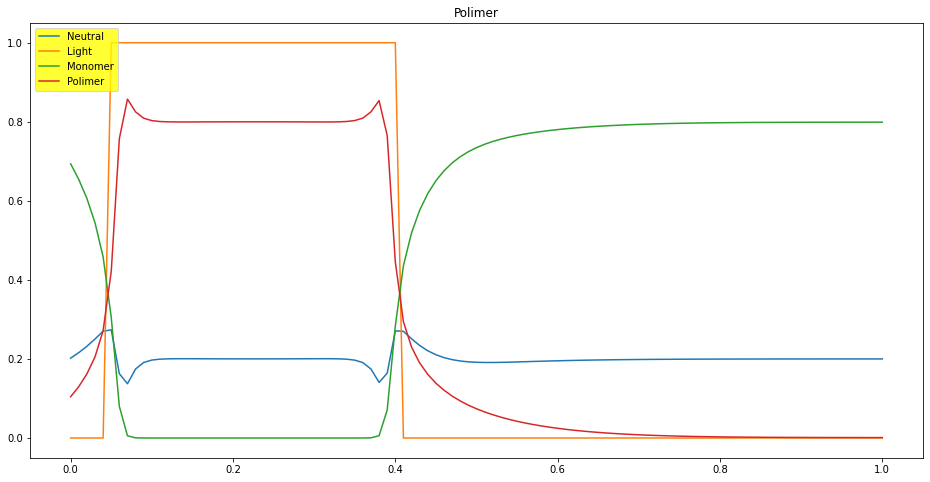

In [4]:
solve(save=True)
draw()